In [72]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
import pickle
import re
import numpy as np
from scipy import stats


In [73]:
def extract_ranking(text):
    if pd.isna(text) or not isinstance(text, str):
        return None
    # Remove commas from the text before converting to integer
    text = text.replace(',', '')
    match = re.search(r'#([\d,]+)', text)
    if match:
        return int(match.group(1))
    return None

def extract_purchase_count(text):
    if pd.isna(text) or not isinstance(text, str) or text.strip() == '':
        return 0
    match = re.match(r'(\d+)([Kk]?)\+', text)
    if match:
        number = int(match.group(1))
        if match.group(2).lower() == 'k':
            number *= 1000
        return number
    return 0

def clean_rating(text):
    if pd.isna(text) or not isinstance(text, str):
        return None
    match = re.match(r'^(\d+(\.\d)?|\.\d)$', text.strip())
    if match:
        return float(text)
    return None

def clean_review_count(text):
    if pd.isna(text) or not isinstance(text, str):
        return None
    # Check if the text is a valid integer or a string with commas
    if text.isdigit():  # Check if the text is a valid integer
        return int(text)
    else:  # Handle strings with commas
        # Remove commas from the text before converting to integer
        text = text.replace(',', '')
        try:
            return int(text)
        except ValueError:
            return None

input_file_path = 'C:\\Users\\kongj\\Desktop\\Trendiness Model\\amazon_data.csv'
output_file_path = 'C:\\Users\\kongj\\Desktop\\Trendiness Model\\trendiness_data_cleaned.csv'

df = pd.read_csv(input_file_path)

# Convert 'rating' and 'review_count' columns to integers
df['rating'] = df['rating'].apply(clean_rating)

# Apply cleaning functions to other columns
df['review_count'] = df['review_count'].apply(clean_review_count)
df['rankings'] = df['rankings'].apply(extract_ranking)
df['purchase_cnt_prev_month'] = df['purchase_cnt_prev_month'].apply(extract_purchase_count)
df.dropna(inplace=True, subset=['review_count', 'rankings', 'rating', 'purchase_cnt_prev_month'])

# Select cleaned columns and export to CSV
df_cleaned = df[['rating', 'review_count', 'rankings', 'purchase_cnt_prev_month']]
df_cleaned.to_csv(output_file_path, index=False)
df.to_csv('C:\\Users\\kongj\\Desktop\\Trendiness Model\\amazon_cleaned.csv')

C:\Users\kongj\AppData\Local\Temp\ipykernel_28184\4248249181.py:47: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(input_file_path)


In [74]:
# Load the data
data = pd.read_csv('trendiness_data_cleaned.csv')

# Normalize the data
scaler = MinMaxScaler()
data[['purchase_cnt_prev_month', 'review_count', 'rating']] = scaler.fit_transform(data[['purchase_cnt_prev_month', 'review_count', 'rating']])
data['rankings'] = 1 - (data['rankings'] / data['rankings'].max())

# Calculate proxy labels for trendiness
data['trendiness'] = (
    0.35 * data['purchase_cnt_prev_month'] +
    0.25 * data['rankings'] +
    0.2 * data['rating'] +
    0.2 * data['review_count']
)

# Calculate proxy labels for uniqueness
data['uniqueness'] = (
    1 * data['rating'] - 
    0.4 * data['purchase_cnt_prev_month'] - 
    0.3 * data['rankings'] - 
    0.3 * data['review_count']
)

# Normalize the uniqueness scores to be between 0 and 1
uniqueness_scaler = MinMaxScaler()
data['uniqueness'] = uniqueness_scaler.fit_transform(data[['uniqueness']])

# Save the proxy labeled data to a CSV file
data.to_csv('labeled_trendiness_uniqueness_data.csv', index=False)

In [75]:
# Define the PyTorch dataset
class TrendinessUniquenessDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe[['rating', 'review_count', 'rankings', 'purchase_cnt_prev_month']].values
        self.trendiness_labels = dataframe['trendiness'].values
        self.uniqueness_labels = dataframe['uniqueness'].values

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return (torch.tensor(self.data[idx], dtype=torch.float32), 
                torch.tensor(self.trendiness_labels[idx], dtype=torch.float32),
                torch.tensor(self.uniqueness_labels[idx], dtype=torch.float32))

In [76]:
# Define the PyTorch model
class TrendinessModel(nn.Module):
    def __init__(self):
        super(TrendinessModel, self).__init__()
        self.fc1 = nn.Linear(4, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3_trendiness = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        trendiness = self.sigmoid(self.fc3_trendiness(x))
        return trendiness

In [77]:
# Define the PyTorch model
class UniquenessModel(nn.Module):
    def __init__(self):
        super(UniquenessModel, self).__init__()
        self.fc1 = nn.Linear(4, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3_uniqueness = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        uniqueness = self.sigmoid(self.fc3_uniqueness(x))
        return uniqueness

In [78]:
dataset = TrendinessUniquenessDataset(data)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [79]:
# Initialize model, optimizer, and loss function
trendiness_model = TrendinessModel()
optimizer = optim.Adam(trendiness_model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Train the model
num_epochs = 10
for epoch in range(num_epochs):
    trendiness_model.train()
    train_loss = 0
    for inputs, trendiness_labels, uniqueness_labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        optimizer.zero_grad()
        trendiness_outputs = trendiness_model(inputs)
        loss_trendiness = criterion(trendiness_outputs.squeeze(), trendiness_labels)
        loss_trendiness.backward()
        optimizer.step()
        train_loss += loss_trendiness.item()
    train_loss /= len(train_loader)
    print(f'Epoch {epoch+1}, Training Loss: {train_loss}')

# Save the trained model using pickle
with open('trendiness_model.pkl', 'wb') as f:
    pickle.dump(trendiness_model.state_dict(), f)

Epoch 1/10: 100%|██████████| 948/948 [00:01<00:00, 672.41it/s]


Epoch 1, Training Loss: 0.0001519873014938146


Epoch 2/10: 100%|██████████| 948/948 [00:01<00:00, 698.70it/s]


Epoch 2, Training Loss: 9.934118213931147e-06


Epoch 3/10: 100%|██████████| 948/948 [00:01<00:00, 670.73it/s]


Epoch 3, Training Loss: 1.2715978640611813e-06


Epoch 4/10: 100%|██████████| 948/948 [00:01<00:00, 688.63it/s]


Epoch 4, Training Loss: 1.0113224812818446e-06


Epoch 5/10: 100%|██████████| 948/948 [00:01<00:00, 689.80it/s]


Epoch 5, Training Loss: 8.253124021579483e-07


Epoch 6/10: 100%|██████████| 948/948 [00:01<00:00, 651.59it/s]


Epoch 6, Training Loss: 7.019539144622334e-07


Epoch 7/10: 100%|██████████| 948/948 [00:01<00:00, 699.65it/s]


Epoch 7, Training Loss: 7.430665440587789e-07


Epoch 8/10: 100%|██████████| 948/948 [00:01<00:00, 713.93it/s]


Epoch 8, Training Loss: 4.7155936742861985e-07


Epoch 9/10: 100%|██████████| 948/948 [00:01<00:00, 682.84it/s]


Epoch 9, Training Loss: 4.68547735885784e-07


Epoch 10/10: 100%|██████████| 948/948 [00:01<00:00, 715.72it/s]

Epoch 10, Training Loss: 4.3818150038638304e-07


In [80]:
# Initialize model, optimizer, and loss function
uniqueness_model = UniquenessModel()
optimizer = optim.Adam(uniqueness_model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Train the model
num_epochs = 10
for epoch in range(num_epochs):
    uniqueness_model.train()
    train_loss = 0
    for inputs, trendiness_labels, uniqueness_labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        optimizer.zero_grad()
        uniqueness_outputs = uniqueness_model(inputs)
        loss_uniqueness = criterion(uniqueness_outputs.squeeze(), uniqueness_labels)
        loss_uniqueness.backward()
        optimizer.step()
        train_loss += loss_uniqueness.item()
    train_loss /= len(train_loader)
    print(f'Epoch {epoch+1}, Training Loss: {train_loss}')

# Save the trained model using pickle
with open('uniqueness_model.pkl', 'wb') as f:
    pickle.dump(uniqueness_model.state_dict(), f)

Epoch 1/10: 100%|██████████| 948/948 [00:01<00:00, 724.05it/s]


Epoch 1, Training Loss: 0.0012332406649479594


Epoch 2/10: 100%|██████████| 948/948 [00:01<00:00, 697.08it/s]


Epoch 2, Training Loss: 1.9041730144829264e-05


Epoch 3/10: 100%|██████████| 948/948 [00:01<00:00, 714.28it/s]


Epoch 3, Training Loss: 9.698779912405956e-06


Epoch 4/10: 100%|██████████| 948/948 [00:01<00:00, 689.06it/s]


Epoch 4, Training Loss: 6.8157778671531625e-06


Epoch 5/10: 100%|██████████| 948/948 [00:01<00:00, 685.31it/s]


Epoch 5, Training Loss: 5.262657375011452e-06


Epoch 6/10: 100%|██████████| 948/948 [00:01<00:00, 601.63it/s]


Epoch 6, Training Loss: 4.712958974203153e-06


Epoch 7/10: 100%|██████████| 948/948 [00:01<00:00, 644.01it/s]


Epoch 7, Training Loss: 4.20372013158151e-06


Epoch 8/10: 100%|██████████| 948/948 [00:01<00:00, 658.85it/s]


Epoch 8, Training Loss: 3.7522062076783103e-06


Epoch 9/10: 100%|██████████| 948/948 [00:01<00:00, 670.20it/s]


Epoch 9, Training Loss: 3.127305632383305e-06


Epoch 10/10: 100%|██████████| 948/948 [00:01<00:00, 636.00it/s]

Epoch 10, Training Loss: 3.023792997482757e-06


In [81]:
# Define the prediction function using the trained models
def predict_trendiness_uniqueness(new_data, trendiness_model, uniqueness_model, scaler):
    new_data[['purchase_cnt_prev_month', 'review_count', 'rating']] = scaler.transform(new_data[['purchase_cnt_prev_month', 'review_count', 'rating']])
    new_data['rankings'] = 1 - (new_data['rankings'] / new_data['rankings'].max())
    inputs = torch.tensor(new_data[['rating', 'review_count', 'rankings', 'purchase_cnt_prev_month']].astype('float32').values)
    
    trendiness_model.eval()
    uniqueness_model.eval()
    
    with torch.no_grad():
        trendiness_outputs = trendiness_model(inputs)
        uniqueness_outputs = uniqueness_model(inputs)
    
    trendiness_scores = trendiness_outputs.squeeze().numpy()
    uniqueness_scores = uniqueness_outputs.squeeze().numpy()
    
    return trendiness_scores, uniqueness_scores

# Load the models for prediction
loaded_trendiness_model = TrendinessModel()
loaded_uniqueness_model = UniquenessModel()

# Load state dicts from the pickle files
with open('trendiness_model.pkl', 'rb') as f:
    loaded_trendiness_model.load_state_dict(pickle.load(f))

with open('uniqueness_model.pkl', 'rb') as f:
    loaded_uniqueness_model.load_state_dict(pickle.load(f))

# Example new data point
new_data_point = [[5.0, 2395.0, 263.0, 100000]]
new_data = pd.DataFrame(new_data_point, columns=['rating', 'review_count', 'rankings', 'purchase_cnt_prev_month'])

# Predict trendiness and uniqueness scores
trendiness_score, uniqueness_score = predict_trendiness_uniqueness(new_data, loaded_trendiness_model, loaded_uniqueness_model, scaler)
print(f"Predicted trendiness score: {trendiness_score}")
print(f"Predicted uniqueness score: {uniqueness_score}")


Predicted trendiness score: 0.47349998354911804
Predicted uniqueness score: 0.6974851489067078


In [83]:
# Load the model for prediction
loaded_trendiness_model = TrendinessModel()
loaded_uniqueness_model = UniquenessModel()

# Load state dicts from the pickle files
with open('trendiness_model.pkl', 'rb') as f:
    loaded_trendiness_model.load_state_dict(pickle.load(f))

with open('uniqueness_model.pkl', 'rb') as f:
    loaded_uniqueness_model.load_state_dict(pickle.load(f))

# Load and process the input CSV
amazon_df = pd.read_csv('amazon_cleaned.csv')

# Initialize lists to store the predictions
trendiness_scores = []
uniqueness_scores = []

# Loop through each row in the DataFrame and make predictions
for index, row in amazon_df.iterrows():
    new_data_point = row.to_frame().T
    trendiness_score, uniqueness_score = predict_trendiness_uniqueness(new_data_point, loaded_trendiness_model, loaded_uniqueness_model, scaler)
    trendiness_scores.append(trendiness_score)  # Ensure to access the first element if predictions are in arrays
    uniqueness_scores.append(uniqueness_score)  # Ensure to access the first element if predictions are in arrays

# Add the scores to the DataFrame
amazon_df['predicted_trendiness'] = trendiness_scores
amazon_df['predicted_uniqueness'] = uniqueness_scores

# Ensure columns are numeric
amazon_df['predicted_trendiness'] = amazon_df['predicted_trendiness'].astype(float)
amazon_df['predicted_uniqueness'] = amazon_df['predicted_uniqueness'].astype(float)

# Calculate Z-scores for predicted_trendiness and predicted_uniqueness
amazon_df['trendiness_zscore'] = np.abs(stats.zscore(amazon_df['predicted_trendiness']))
amazon_df['uniqueness_zscore'] = np.abs(stats.zscore(amazon_df['predicted_uniqueness']))

# Define threshold for outliers (e.g., Z-score > 3)
threshold = 3
outliers = amazon_df[(amazon_df['trendiness_zscore'] > threshold) | (amazon_df['uniqueness_zscore'] > threshold)]

# Remove outliers
amazon_df = amazon_df[~((amazon_df['trendiness_zscore'] > threshold) | (amazon_df['uniqueness_zscore'] > threshold))]

# Normalize the predicted scores after removing outliers
scaler_trendiness = MinMaxScaler()
scaler_uniqueness = MinMaxScaler()

amazon_df[['predicted_trendiness']] = scaler_trendiness.fit_transform(amazon_df[['predicted_trendiness']])
amazon_df[['predicted_uniqueness']] = scaler_uniqueness.fit_transform(amazon_df[['predicted_uniqueness']])

# Save the results to a new CSV
output_file_path = 'C:\\Users\\kongj\\Desktop\\Trendiness Model\\amazon_no_outliers_normalized.csv'
amazon_df.to_csv(output_file_path, index=False)
print(f"Data without outliers and normalized saved to {output_file_path}")

Data without outliers and normalized saved to C:\Users\kongj\Desktop\Trendiness Model\amazon_no_outliers_normalized.csv


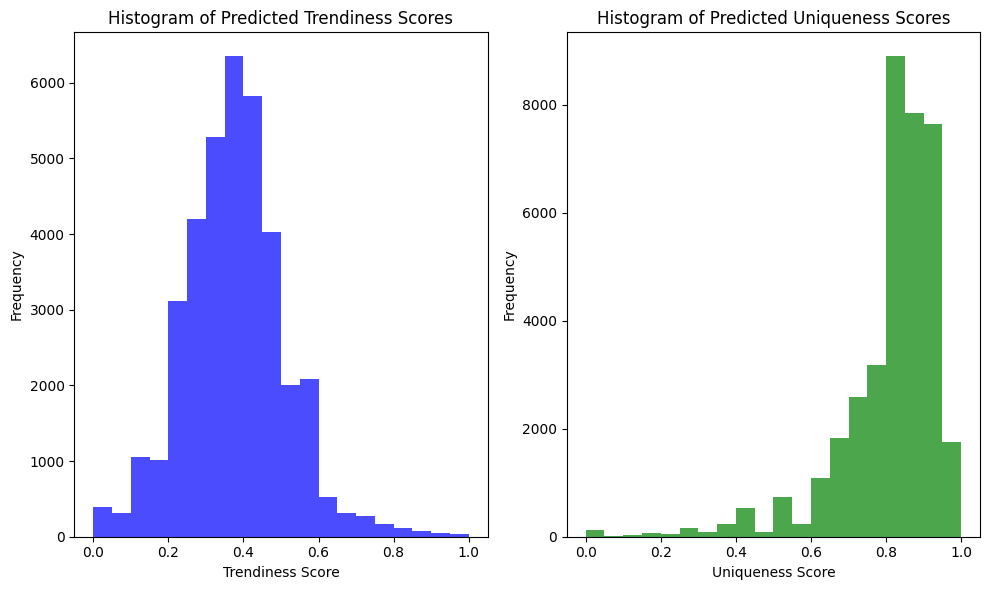

In [85]:
import matplotlib.pyplot as plt

# Load the predictions CSV
predictions_df = pd.read_csv('C:\\Users\\kongj\\Desktop\\Trendiness Model\\amazon_no_outliers_normalized.csv')

# Plotting histograms
plt.figure(figsize=(10, 6))

# Histogram for predicted trendiness
plt.subplot(1, 2, 1)
plt.hist(predictions_df['predicted_trendiness'], bins=20, color='blue', alpha=0.7)
plt.title('Histogram of Predicted Trendiness Scores')
plt.xlabel('Trendiness Score')
plt.ylabel('Frequency')

# Histogram for predicted uniqueness
plt.subplot(1, 2, 2)
plt.hist(predictions_df['predicted_uniqueness'], bins=20, color='green', alpha=0.7)
plt.title('Histogram of Predicted Uniqueness Scores')
plt.xlabel('Uniqueness Score')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


In [86]:
# Load the predictions CSV
predictions_df = pd.read_csv('C:\\Users\\kongj\\Desktop\\Trendiness Model\\amazon_no_outliers_normalized.csv')

# Initialize an empty DataFrame to store sampled data
sampled_data = pd.DataFrame()

# Group by 'main_category' and sample 500 random data points for each group
grouped = predictions_df.groupby('main_category')
for category, group in grouped:
    sampled_group = group.sample(n=min(500, len(group)))  # Sample up to 500 data points per category
    sampled_data = pd.concat([sampled_data, sampled_group])

# Save the sampled data to a new CSV file
output_file_path = 'C:\\Users\\kongj\\Desktop\\Trendiness Model\\amazon_sample_data.csv'
sampled_data.to_csv(output_file_path, index=False)
print(f"Sampled data saved to {output_file_path}")

Sampled data saved to C:\Users\kongj\Desktop\Trendiness Model\amazon_sample_data.csv
